An attempt to get geo working for our data 

## Open Street maps:

[Old walkthrough](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)

[Documentation](https://osmnx.readthedocs.io)

[plotting examples from the oosmnx](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/01-overview-osmnx.ipynb):

## Geopandas

## pygadm

We get our data using [pygadm](https://pypi.org/project/pygadm/).


In [45]:
countries=["Indonesia","Timor-Leste","Philippines","Papua New Guinea",
           "Brunei","Singapore","Malaysia","Vietnam","Cambodia","Thailand","Laos","Myanmar"]

In [55]:
import geonamescache

gc = geonamescache.GeonamesCache()
# gc.get_cities()
#geo_plug.all_State_CityNames("Jakarta")# name == 'all' or state name
#geo_plug.all_State_CityNames('Odisha')

In [57]:
data

[['Jakarta', 'Manilla'], [-6.1944, 14.5995], [106.8229, 120.9842]]

In [102]:
cities=['Jakarta','Manilla']
lat=[106.8229,120.9842]
long=[-6.1944,14.5995]
data = {"Name": cities,"Long":long,"Lat":lat}
cities_df = pd.DataFrame(data)
cities_df['coords'] = list(zip(cities_df.Long, cities_df.Lat))
cities_df

,Name,Long,Lat,coords
0,Jakarta,-6.1944,106.8229,"(-6.1944, 106.8229)"
1,Manilla,14.5995,120.9842,"(14.5995, 120.9842)"


In [100]:
from shapely.geometry import Point

In [104]:
#import geopandas as gpd
#import osmnx as ox
#from pathlib import Path
import pygadm
import csv
import geopandas as gpd

In [2]:
# Get the list of all country names available in pygadm
names=pygadm.Names().to_numpy()
with open('data/pygadm_names.csv','w',newline='') as f:
        writer = csv.writer(f)
        writer.writerows(names)

In [8]:
%matplotlib inline

In [69]:
gdf = pygadm.Items(name=countries, content_level=1)
#gdf.plot()

In [103]:
geo_df = gpd.GeoDataFrame(
    df, crs  ={'init': 'epsg:4326'},
    geometry = df['coords'].apply(Point)
).to_crs(epsg=3857)

NameError: name 'gpd' is not defined

In [25]:
bb=(95,-10.4,152,18.7)
bblong=[bb[i] for i in (0,2)]
bblat=[bb[i] for i in (1,3)]

(95.0, 152.0, -10.4, 18.7)

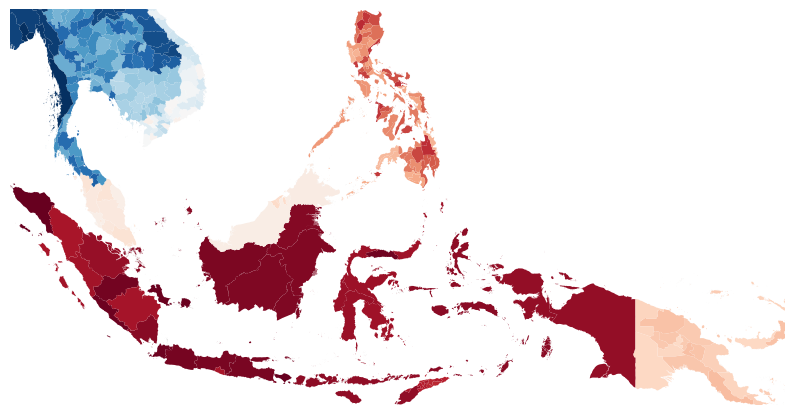

In [106]:
ax = gdf.plot(figsize=(10, 10), cmap='RdBu')
ax.set_xlim(bblong)
ax.set_ylim(bblat)
ax.axis('off')
#ax.scatter(cities_df["Long"], cities_df["Lat"], s= 100,color='black', zorder=5)
# Add city labels
#for i, row in cities_df.iterrows():
#    ax.text(row["Long"] + 0.5, row["Lat"], row["Name"], fontsize=9, color='black')

In [38]:
import elevatr as elv
# [elevatr documentation](https://elevatr.readthedocs.io/en/stable/)

In [29]:
# Set the level of precision (between 0 and 14)
zoom = 6

# Access the elevation data
raster = elv.get_elev_raster(locations=bb, zoom=zoom)

Mosaicing tiles.


In [37]:
?raster

Type:        Raster
String form:
Raster(data=array([[   31,    30,    35, ..., -5589, -5606, -5616],
           [   33,    28,    31,  <...> ': 1222.9924525628194, 'y': 1222.992452562819, 'unit': 'metre'}, imagery_sources='etopo1, gmted')
File:        ~/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/elevatr/raster.py
Docstring:   A class to manage raster data.

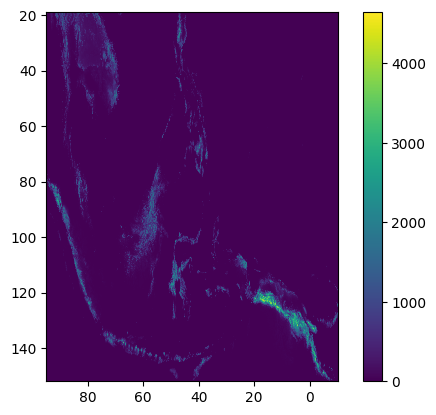

In [99]:
import numpy as np
from matplotlib import pyplot as plt
raster_array = raster.to_numpy() # Converts to numpy
plt.imshow(raster_array, interpolation='nearest',vmin = 0,extent =bb)
plt.colorbar()
plt.show()

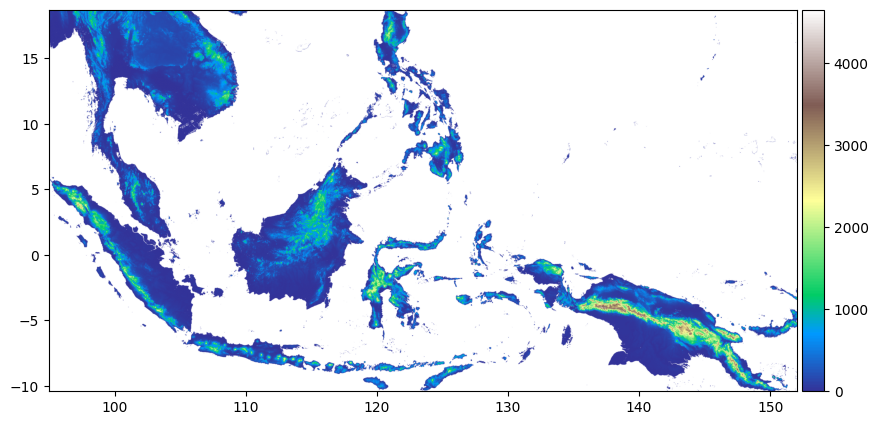

<Axes: >

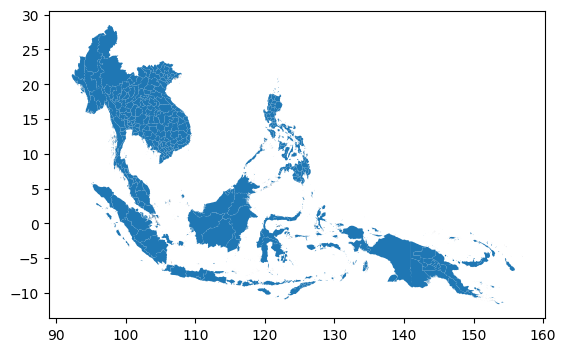

In [40]:
raster.reproject(crs="EPSG:4326") # World Geodesic System
# raster_array = raster.to_numpy() # Converts to numpy
raster.show(cmap='terrain', clip_zero=True,clip_color="white")

In [5]:
import pandas as pd
wordlistdata=pd.read_excel('Wordlists_collected_Master_REFERENCE.xlsx', index_col=0)  

In [ ]:
from geotext import GeoText
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [ ]:
def geo_lookup(place):
    if(place.__class__)!='str':
        return("")        
    if(len(place)>1):
        return(GeoText(place))
    else:
        return("")

In [ ]:
GeoText("Bunggeta, Alor").countries

In [ ]:
for f in wordlistdata["Where collected"]:
    print(f.__class__)
    places = geo_lookup(f)
    print(f,places)

In [ ]:
#G = ox.graph.graph_from_place("Bunggeta, Alor")
#fig, ax = ox.plot.plot_graph(G)

In [ ]:
wordlistdata